# Building intelligent bots. Retrieval-based chatbots

In this section we build a retrieval-based chatbot with Rasa. Before we go to this point, we go through a few NLP methods and word vectorization.


## NLP methods for NLU

Let's take one of President Trump's speech and divide into words.

In [1]:
import spacy

file = open("trump.txt", "r",encoding='utf-8') 
trump = file.read() 

nlp = spacy.load("en")
doc = nlp(trump)

for span in doc.sents:
    print("> ", span)

>  Thank you, everybody.
>  Thank you.
>  Thank you very much.
>  Thank you, Matt, for that great introduction.
>  And thank you for this big crowd.
>  This is incredible.
>  Really incredible.
>  We have all come a long way together.
>  We have come a long way together.

>  I’m thrilled to be back at CPAC, with so many of my wonderful friends and amazing supporters and proud conservatives.
>  Remember when I first started running?
>  Because I wasn’t a politician, fortunately, but do you remember I started running and people said, are you sure he’s a conservative?
>  I think I proved I’m a conservative.

>  For more than four decades, this event has served as a forum for our nation’s top leaders, activists, writers, and thinkers.

>  Year after year, leaders have stood on this stage to discuss what we can do together to protect our heritage, to promote our culture, and to defend our freedom.
>  CPAC has always been about big ideas, and it has also been about putting those ideas into a

We have are able to divide it using SpaCy and get the part of speech of each word.

In [2]:
for span in doc.sents:
    for i in range(span.start, span.end):
        token = doc[i]
        print(i, token.text, token.pos_)    

0 Thank VERB
1 you PRON
2 , PUNCT
3 everybody PRON
4 . PUNCT
5 Thank VERB
6 you PRON
7 . PUNCT
8 Thank VERB
9 you PRON
10 very ADV
11 much ADV
12 . PUNCT
13 Thank VERB
14 you PRON
15 , PUNCT
16 Matt PROPN
17 , PUNCT
18 for ADP
19 that DET
20 great ADJ
21 introduction NOUN
22 . PUNCT
23 And CCONJ
24 thank VERB
25 you PRON
26 for ADP
27 this DET
28 big ADJ
29 crowd NOUN
30 . PUNCT
31 This DET
32 is AUX
33 incredible ADJ
34 . PUNCT
35 Really ADV
36 incredible ADJ
37 . PUNCT
38 We PRON
39 have AUX
40 all ADV
41 come VERB
42 a DET
43 long ADJ
44 way NOUN
45 together ADV
46 . PUNCT
47 We PRON
48 have AUX
49 come VERB
50 a DET
51 long ADJ
52 way NOUN
53 together ADV
54 . PUNCT
55 
 SPACE
56 I PRON
57 ’m VERB
58 thrilled ADJ
59 to PART
60 be AUX
61 back ADV
62 at ADP
63 CPAC PROPN
64 , PUNCT
65 with ADP
66 so ADV
67 many ADJ
68 of ADP
69 my PRON
70 wonderful ADJ
71 friends NOUN
72 and CCONJ
73 amazing ADJ
74 supporters NOUN
75 and CCONJ
76 proud ADJ
77 conservatives NOUN
78 . PUNCT
79 Remember

A smaller example:

In [3]:
sample = "Broadcasting today, live from Kraków, on chatbots."

doc = nlp(sample)
for token in doc:
    print(token.text, token.pos_)

Broadcasting PROPN
today NOUN
, PUNCT
live ADV
from ADP
Kraków PROPN
, PUNCT
on ADP
chatbots NOUN
. PUNCT


### Noun chunks

This NLP method is used to get the nouns from any sentene. It's important to understand what is the sentence about.

In [4]:
doc = nlp(sample)
for nc in doc.noun_chunks:
    print(nc)

Kraków
chatbots


### Named Entity Recognition

NER is a NLP method where we get not the nouns or part of speech, but meanings of the words.

In [5]:
doc = nlp(sample)
for entity in doc.ents:
    print(entity.label_, entity.text)

DATE today
GPE Kraków


## Word vectorization

Word vectorization is a process of preparing a vector representing each word. Gensim has an implementation of Word2Vec. We use a dimension of 100 and distance between two words in a sentence to 5.

In [6]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

We can get the vocabulary as follows:

In [7]:
vocab = list(model.wv.vocab)
X = model[vocab]
print(vocab[0])

human


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


To train we just use the TSNE to reduce the dimensionality:

In [8]:
from sklearn.manifold import TSNE
import pandas as pd

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df

,x,y
human,234.548721,-163.857681
interface,11.533824,-125.698242
computer,-259.990326,177.726364
survey,319.183319,67.650078
user,-145.300079,-17.329945
system,48.006931,-325.026062
response,119.843498,31.176579
time,-73.440628,338.882019
eps,-36.990463,139.544861
trees,158.066574,254.191193


We can draw the words in a two-dimensional space:

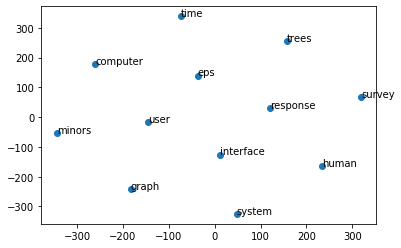

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()    

## Negative sampling

It is a simpler implementation of word2vec. It is faster as it takes only a few terms in each iteration for training insted of the whole dataset as in previous example. This is why it's called negative sampling.

First of all, we define helper methods that are used later.

In [12]:
import numpy as np

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def randn(*dims):
    return np.random.randn(*dims).astype(np.float32)

def sigmoid(batch, stochastic=False):
    return  1.0 / (1.0 + np.exp(-batch))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

In [13]:
import pickle
import gzip

with gzip.open("datasets/text8.dat.gz", "rb") as f:
    train_dict, train_set, train_tokens = pickle.load(f)

train_set = np.random.permutation(train_set)

In [14]:
from collections import namedtuple
Config = namedtuple("Config", ["dict_size", "vect_size", "neg_samples", "updates", "learning_rate", 
                               "learning_rate_decay", "decay_period", "log_period"])
conf = Config(
    dict_size=len(train_dict),
    vect_size=100,
    neg_samples=10,
    updates=5000000,
    learning_rate=0.1,
    learning_rate_decay=0.995,
    decay_period=10000,
    log_period=10000)

In [15]:
def neg_sample(conf, train_set, train_tokens): # implemented
    Vp = randn(conf.dict_size, conf.vect_size)
    Vo = randn(conf.dict_size, conf.vect_size)

    J = 0.0
    learning_rate = conf.learning_rate
    for i in range(conf.updates):
        idx = i % len(train_set)

        word    = train_set[idx, 0]
        context = train_set[idx, 1]
        
        neg_context = np.random.randint(0, len(train_tokens), conf.neg_samples)
        neg_context = train_tokens[neg_context]

        word_vect = Vp[word, :]              # word vector
        context_vect = Vo[context, :];       # context wector
        negative_vects = Vo[neg_context, :]  # sampled negative vectors

        # Cost and gradient calculation starts here
        score_pos = word_vect @ context_vect.T
        score_neg = word_vect @ negative_vects.T

        J -= np.log(sigmoid(score_pos)) + np.sum(np.log(sigmoid(-score_neg)))
        if (i + 1) % conf.log_period == 0:
            print('Update {0}\tcost: {1:>2.2f}'.format(i + 1, J / conf.log_period))
            final_cost = J / conf.log_period
            J = 0.0

        pos_g = 1.0 - sigmoid(score_pos)
        neg_g = sigmoid(score_neg)

        word_grad = -pos_g * context_vect + np.sum(as_matrix(neg_g) * negative_vects, axis=0)
        context_grad = -pos_g * word_vect
        neg_context_grad = as_matrix(neg_g) * as_matrix(word_vect).T

        Vp[word, :] -= learning_rate * word_grad
        Vo[context, :] -= learning_rate * context_grad
        Vo[neg_context, :] -= learning_rate * neg_context_grad

        if i % conf.decay_period == 0:
            learning_rate = learning_rate * conf.learning_rate_decay

    return Vp, Vo, final_cost

In [16]:
Vp, Vo, J = neg_sample(conf, train_set, train_tokens)

Update 10000	cost: 36.24
Update 20000	cost: 28.56
Update 30000	cost: 23.27
Update 40000	cost: 19.40
Update 50000	cost: 17.25
Update 60000	cost: 15.22
Update 70000	cost: 14.06
Update 80000	cost: 13.08
Update 90000	cost: 12.25
Update 100000	cost: 11.50
Update 110000	cost: 10.96
Update 120000	cost: 10.44
Update 130000	cost: 10.13
Update 140000	cost: 9.77
Update 150000	cost: 9.29
Update 160000	cost: 9.24
Update 170000	cost: 8.77
Update 180000	cost: 8.56
Update 190000	cost: 8.35
Update 200000	cost: 8.25
Update 210000	cost: 8.03
Update 220000	cost: 7.79
Update 230000	cost: 7.60
Update 240000	cost: 7.55
Update 250000	cost: 7.46
Update 260000	cost: 7.40
Update 270000	cost: 7.19
Update 280000	cost: 7.05
Update 290000	cost: 7.05
Update 300000	cost: 6.89
Update 310000	cost: 6.87
Update 320000	cost: 6.83
Update 330000	cost: 6.63
Update 340000	cost: 6.57
Update 350000	cost: 6.52
Update 360000	cost: 6.44
Update 370000	cost: 6.38
Update 380000	cost: 6.30
Update 390000	cost: 6.26
Update 400000	cost: 6

In [17]:
def lookup_word_idx(word, word_dict):
    try:
        return np.argwhere(np.array(word_dict) == word)[0][0]
    except:
        raise Exception("No such word in dict: {}".format(word))

def similar_words(embeddings, word, word_dict, hits):
    word_idx = lookup_word_idx(word, word_dict)
    similarity_scores = embeddings @ embeddings[word_idx]
    similar_word_idxs = np.argsort(-similarity_scores)    
    return [word_dict[i] for i in similar_word_idxs[:hits]]

In [18]:
print('\n\nTraining cost: {0:>2.2f}\n\n'.format(J))

sample_words = ['zero', 'computer', 'cars', 'home', 'album']

Vp_norm = Vp / as_matrix(np.linalg.norm(Vp , axis=1))
for w in sample_words:
    similar = similar_words(Vp_norm, w, train_dict, 5)
    print('Words similar to {}: {}'.format(w, ", ".join(similar)))



Training cost: 3.45


Words similar to zero: zero, four, five, three, eight
Words similar to computer: computer, computers, systems, software, digital
Words similar to cars: cars, performance, even, amount, rare
Words similar to home: home, first, well, company, team
Words similar to album: album, song, released, band, music


### Similarity measure through vectors

SpaCy already has words vectorized and we can simply check the similarity between two sentences.

In [19]:
import spacy

nlp = spacy.load('en')

doc1 = nlp(u"Warsaw is the largest city in Poland.")
doc2 = nlp(u"Crossaint is baked in France.")
doc3 = nlp(u"An emu is a large bird.")

for doc in [doc1, doc2, doc3]:
    for other_doc in [doc1, doc2, doc3]:
        print(doc.similarity(other_doc))

1.0
0.7141499079552157
0.6306364163302318
0.7141499079552157
1.0
0.5037601918826777
0.6306364163302318
0.5037601918826777
1.0


/usr/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if

A nice example of word vectorization done by some researchers at Warsaw University: [Word2Vec](https://lamyiowce.github.io/word2viz/).

## Retrieval-based chatbot

In this section we use Rasa to build a very simple HR assistant bot. We can use Rasa as a server or use it directly from Python level. Before we start the bot, let's create a directory where the new project will be placed.

In [1]:
!mkdir assistant

We can create a new project with the ``init`` command. The command create the project structure and train the model with the default intents and stories.

In [2]:
!cd assistant && PYTHONIOENCODING='utf8' rasa init --no-prompt

Welcome to Rasa! ����

To get started quickly, an initial project will be created.
If you need some help, check out the documentation at https://rasa.com/docs/rasa.

Created project directory at '/home/codete/workshop/assistant'.
Finished creating project structure.
Training an initial model...
Training Core model...
2019-11-18 12:49:45 INFO     absl  - Entry Point [tensor2tensor.envs.tic_tac_toe_env:TicTacToeEnv] registered with id [T2TEnv-TicTacToeEnv-v0]
Processed trackers: 100%|������������������������������| 5/5 [00:00<00:00, 277.12it/s, # actions=16]
Processed actions: 16it [00:00, 607.27it/s, # examples=16]
Processed trackers: 100%|���������������| 231/231 [00:02<00:00, 104.40it/s, # actions=126]
2019-11-18 12:49:48.561009: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (M

The structure of the created project looks like following:

In [3]:
!ls assistant

__init__.py  actions.py  credentials.yml  domain.yml
__pycache__  config.yml  data		  endpoints.yml


There are two directories: 

- ``data`` where all intents and stories are placed,
- ``models`` where trained models are placed.

The intents are stored in ``nlu.md`` and stories in ``stories.md``. Models are stored as ``.tar.gz`` files with the data in the name. 

Other files that are in the main directory are:

- actions.py - contains custom actions,
- config.yml - the pipeline, language and other configuration details,
- credentials.yml - credentials to platforms like messenger, slack, and other,
- domain.yml - utters set,
- endpoints.yml - endpoints that the bot can use to get data from outside sources.

We can start a server on default port ``5005``. You can test it using the request package. We should get the intent of the phrase `hi`.

In [4]:
!cd assistant && rasa run --enable-api

2019-11-18 12:50:15 INFO     root  - Starting Rasa server on http://localhost:5005
2019-11-18 12:50:15 WARNING  rasa.core.agent  - Could not load local model in 'models'
^C


We can invoke the ``model/parse`` API to find the intent with the code below. We can find all other API methods that can be called in the documentation: [https://rasa.com/docs/rasa/api/http-api/](https://rasa.com/docs/rasa/api/http-api/).

In [12]:
import requests
import json

def get_intent(sentence):
    url = "http://localhost:5005/model/parse"
    payload = {'text':sentence}
    response = requests.post(url,json=payload)
    return response.json()

get_intent("hi")

{'text': '/hi',
 'intent': {'name': 'hi', 'confidence': 1.0},
 'intent_ranking': [{'name': 'hi', 'confidence': 1.0}],
 'entities': []}

The intents can be defined in ``nlu.md`` as shown below.

In [59]:
! cat assistant/data/nlu.md

## intent:greet
- hey
- hello
- hi
- good morning
- good evening
- hey there

## intent:goodbye
- bye
- goodbye
- see you around
- see you later

## intent:affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- wonderful
- I am feeling very good
- I am great
- I'm good

## intent:mood_unhappy
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not very good
- extremely sad
- so sad

## intent:bot_challenge
- are you a bot?
- are you a human?
- am I talking to a bot?
- am I talking to a human?


We can add more examples by appending other intents as below.

In [13]:
%%writefile -a /home/codete/workshop/assistant/data/nlu.md

## synonym:candidate
- candidate
- developer
- data scientist

## intent:add_candidate
- add [candidate](candidate)
- adding [candidate](candidate)
- please add [candidate](candidate)
- please add new [candidate](candidate)
- we have new prescreening upcoming
- we have a new candidate [candidate](candidate) prescreening

Appending to /home/codete/workshop/assistant/data/nlu.md


The training is straight forward.

In [14]:
!cd assistant && PYTHONIOENCODING='utf8' rasa train

Training Core model...
2019-11-18 13:15:00 INFO     absl  - Entry Point [tensor2tensor.envs.tic_tac_toe_env:TicTacToeEnv] registered with id [T2TEnv-TicTacToeEnv-v0]
Processed trackers: 100%|������������������������������| 5/5 [00:00<00:00, 359.52it/s, # actions=16]
Processed actions: 16it [00:00, 5054.52it/s, # examples=16]
Processed trackers: 100%|���������������| 231/231 [00:00<00:00, 310.22it/s, # actions=126]18]60.94it/s, # actions=126]
2019-11-18 13:15:01.144663: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 21)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6912      
_________________________________________________________________
dense (Dense)

To get the intent we use the parse method as in the previous example. Please remember to start the server first:

In [5]:
!cd assistant && rasa run --enable-api

2019-11-18 13:11:09 INFO     root  - Starting Rasa server on http://localhost:5005
2019-11-18 13:11:09 WARNING  rasa.core.agent  - Could not load local model in 'models'
^C


Now we can check the intents.

In [15]:
def get_intent(sentence):
    url = "http://localhost:5005/model/parse"
    payload = {'text':sentence}
    response = requests.post(url,json=payload)
    return response.json()

get_intent("can we add the candidate?")

{'intent': {'name': 'add_candidate', 'confidence': 0.9999175072},
 'entities': [{'start': 15,
   'end': 24,
   'value': 'candidate',
   'entity': 'candidate',
   'confidence': 0.9031959996,
   'extractor': 'CRFEntityExtractor'}],
 'intent_ranking': [{'name': 'add_candidate', 'confidence': 0.9999175072},
  {'name': 'mood_unhappy', 'confidence': 3.02982e-05},
  {'name': 'deny', 'confidence': 1.47811e-05},
  {'name': 'bot_challenge', 'confidence': 1.15172e-05},
  {'name': 'greet', 'confidence': 1.0192e-05},
  {'name': 'goodbye', 'confidence': 9.412e-06},
  {'name': 'affirm', 'confidence': 4.8702e-06},
  {'name': 'mood_great', 'confidence': 1.3678e-06}],
 'text': 'can we add the candidate?'}

## EXERCISE 2

Extend the training examples and add an intent `change_status` with entities: `passed` and `failed`.

In [29]:
%%writefile /home/codete/workshop/assistant/data/nlu.md

## intent:change_status
- 

Overwriting /home/codete/workshop/assistant/data/nlu.md


Please add the other intents:

In [30]:
%%writefile -a /home/codete/workshop/assistant/data/nlu.md
## intent:greet
- hey
- hello
- hi
- good morning
- good evening
- hey there

## intent:goodbye
- bye
- goodbye
- see you around
- see you later

## intent:affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- wonderful
- I am feeling very good
- I am great
- I'm good

## intent:mood_unhappy
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not very good
- extremely sad
- so sad

## intent:bot_challenge
- are you a bot?
- are you a human?
- am I talking to a bot?
- am I talking to a human?

## synonym:candidate
- candidate
- developer
- data scientist

## intent:add_candidate
- add [candidate](candidate)
- adding [candidate](candidate)
- please add [candidate](candidate)
- please add new [candidate](candidate)
- we have new prescreening upcoming
- we have a new candidate [candidate](candidate) prescreening

Appending to /home/codete/workshop/assistant/data/nlu.md


Train it as in the cell above.

In [31]:
!cd assistant && PYTHONIOENCODING='utf8' rasa train

2019-11-18 14:04:43 INFO     rasa.model  - Data (messages) for NLU model changed.
Core stories/configuration did not change. No need to retrain Core model.
Training NLU model...
2019-11-18 14:04:48 INFO     absl  - Entry Point [tensor2tensor.envs.tic_tac_toe_env:TicTacToeEnv] registered with id [T2TEnv-TicTacToeEnv-v0]
2019-11-18 14:04:49 INFO     rasa.nlu.training_data.training_data  - Training data stats: 
	- intent examples: 55 (9 distinct intents)
	- Found intents: 'greet', 'bot_challenge', 'affirm', 'mood_unhappy', 'mood_great', 'deny', 'goodbye', 'change_status', 'add_candidate'
	- Number of response examples: 0 (0 distinct response)
	- entity examples: 11 (2 distinct entities)
	- found entities: 'candidate', 'status'

2019-11-18 14:04:49 INFO     rasa.nlu.model  - Starting to train component WhitespaceTokenizer
2019-11-18 14:04:49 INFO     rasa.nlu.model  - Finished training component.
2019-11-18 14:04:49 INFO     rasa.nlu.model  - Starting to train component RegexFeaturizer
201

To test the intent we use the parse method as in the previous example. Please remember to start the server first:

In [ ]:
!cd assistant && rasa run --enable-api

Now we can check the intents.

In [34]:
def get_intent(sentence):
    url = "http://localhost:5005/model/parse"
    payload = {'text':sentence}
    response = requests.post(url,json=payload)
    return response.json()

get_intent("the candidate failed the interview")

{'intent': {'name': 'change_status', 'confidence': 0.9999986887},
 'entities': [{'start': 14,
   'end': 20,
   'value': 'failed',
   'entity': 'status',
   'confidence': 0.7578336823,
   'extractor': 'CRFEntityExtractor'}],
 'intent_ranking': [{'name': 'change_status', 'confidence': 0.9999986887},
  {'name': 'affirm', 'confidence': 9.753e-07},
  {'name': 'add_candidate', 'confidence': 1.689e-07},
  {'name': 'mood_great', 'confidence': 8.56e-08},
  {'name': 'mood_unhappy', 'confidence': 2.96e-08},
  {'name': 'greet', 'confidence': 1.04e-08},
  {'name': 'goodbye', 'confidence': 4e-09},
  {'name': 'deny', 'confidence': 1e-09},
  {'name': 'bot_challenge', 'confidence': 1e-10}],
 'text': 'the candidate failed the interview'}

## Building stories with Rasa

To build a chatbot with Rasa that has a focus on the context management, we need to build the dataset of intents as before, but also stories. 

Rasa core for building stories need a bit more configuration than in the previous example. We need to setup the following:
- the configuration of language and machine learning backend,
- setup the domain with sample chatbot responses,
- define the stories.
After this step we need to train Rasa, but we still need feed it with intents after it.

A basic configuration for Rasa is needed like to language and pipeline. The pipeline defines the way how we want to train our dataset.

In [17]:
!cat /home/codete/workshop/assistant/config.yml

# Configuration for Rasa NLU.
# https://rasa.com/docs/rasa/nlu/components/
language: en
pipeline: supervised_embeddings

# Configuration for Rasa Core.
# https://rasa.com/docs/rasa/core/policies/
policies:
  - name: MemoizationPolicy
  - name: KerasPolicy
  - name: MappingPolicy


To test the chatbot stories that are configured to train are set in ``stories.md`` like:

In [7]:
!cat /home/codete/workshop/assistant/data/stories.md

## happy path
* greet
  - utter_greet
* mood_great
  - utter_happy

## sad path 1
* greet
  - utter_greet
* mood_unhappy
  - utter_cheer_up
  - utter_did_that_help
* affirm
  - utter_happy

## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - utter_cheer_up
  - utter_did_that_help
* deny
  - utter_goodbye

## say goodbye
* goodbye
  - utter_goodbye

## bot challenge
* bot_challenge
  - utter_iamabot


We need to set the domain:

In [18]:
!cat /home/codete/workshop/assistant/domain.yml

intents:
  - greet
  - goodbye
  - affirm
  - deny
  - mood_great
  - mood_unhappy
  - bot_challenge

actions:
- utter_greet
- utter_cheer_up
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_iamabot

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_cheer_up:
  - text: "Here is something to cheer you up:"
    image: "https://i.imgur.com/nGF1K8f.jpg"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_happy:
  - text: "Great, carry on!"

  utter_goodbye:
  - text: "Bye"

  utter_iamabot:
  - text: "I am a bot, powered by Rasa."


We can test the bot in Jupyter with the following code:

In [20]:
from rasa.jupyter import chat
import nest_asyncio

nest_asyncio.apply()

model_path = '/home/codete/workshop/assistant/models/20191118-131521.tar.gz'
chat(model_path)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.








INFO:tensorflow:Restoring parameters from /tmp/tmpgl4n03n0/nlu/component_6_EmbeddingIntentClassifier.ckpt


INFO:tensorflow:Restoring parameters from /tmp/tmpgl4n03n0/nlu/component_6_EmbeddingIntentClassifier.ckpt


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Your bot is ready to talk! Type your messages here or send '/stop'.
Hello
Hey! How are you?
Good, thanks
Great, carry on!
Bye
Bye
/stop
